# Read Cython OpenBCI .xdf data

In [33]:
import pyxdf
import PyQt5
import mne
import numpy as np
import pathlib
import mne
import matplotlib
import matplotlib.pyplot as plt
# For interactive plots
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')
from subfunctions import read_xdf, add_annot

## Set data path and read data

In [ ]:
current_path = pathlib.Path().absolute()  
data_fname = current_path /'Data'/'P300_Gilad.xdf'
print(data_fname)
streams, header = pyxdf.load_xdf(data_fname)

/Users/ordez/Documents/BCI_ALS/Data/P300_Gilad.xdf


## before we are able to create a MNE raw instance, we need to create "info" object and prepare the data
(https://mne.tools/stable/auto_tutorials/simulation/10_array_objs.html#sphx-glr-auto-tutorials-simulation-10-array-objs-py)

Look for data[0:13] and data[13:], the first 13 rows should contain the actual electrode while the last 3 contains the Na channels 

In [7]:
stream_count = 0

for stream in streams:
    if stream['info']['channel_count'] == ['16']:
        eeg_stream = stream
        #data_eeg = stream["time_series"].T
        stream_count += 1
    elif stream['info']['channel_count'] == ['1']:
        marker_stream = stream
        stream_count += 1
    else:
        print('Not recognized channel')

    
print (f'{stream_count} streams loaded') 

# Prepare the time series data

eeg_data = eeg_stream["time_series"].T

2 streams loaded


In [8]:
# Create Raw without sim channel

ch_types = ['eeg'] * 13 
ch_names = ['C3','C4','Cz','FC1','FC2','FC5','FC6','CP1','CP2','CP5','CP6','O1','O2']



#data_marker = streams[0]
 
eeg_data = eeg_data[0:13]
#data[:4:2] -= data[1:4:2]  # subtract (rereference) to get two bipolar EEG
#data = data[::2]  # subselect
#data *= 1000
eeg_data *= (1e-6 / 50 / 2)*100  # Not sure if that is the correct way (uV -> V and preamp gain)
sfreq = float(eeg_stream["info"]["nominal_srate"][0])
info = mne.create_info(ch_names= ch_names, ch_types=ch_types, sfreq=sfreq)
info.set_montage('standard_1020')

<Info | 8 non-empty values
 bads: []
 ch_names: C3, C4, Cz, FC1, FC2, FC5, FC6, CP1, CP2, CP5, CP6, O1, O2
 chs: 13 EEG
 custom_ref_applied: False
 dig: 16 items (3 Cardinal, 13 EEG)
 highpass: 0.0 Hz
 lowpass: 62.5 Hz
 meas_date: unspecified
 nchan: 13
 projs: []
 sfreq: 125.0 Hz
>

Creating RawArray with float64 data, n_channels=13, n_times=31405
    Range : 0 ... 31404 =      0.000 ...   251.232 secs
Ready.
Using matplotlib as 2D backend.


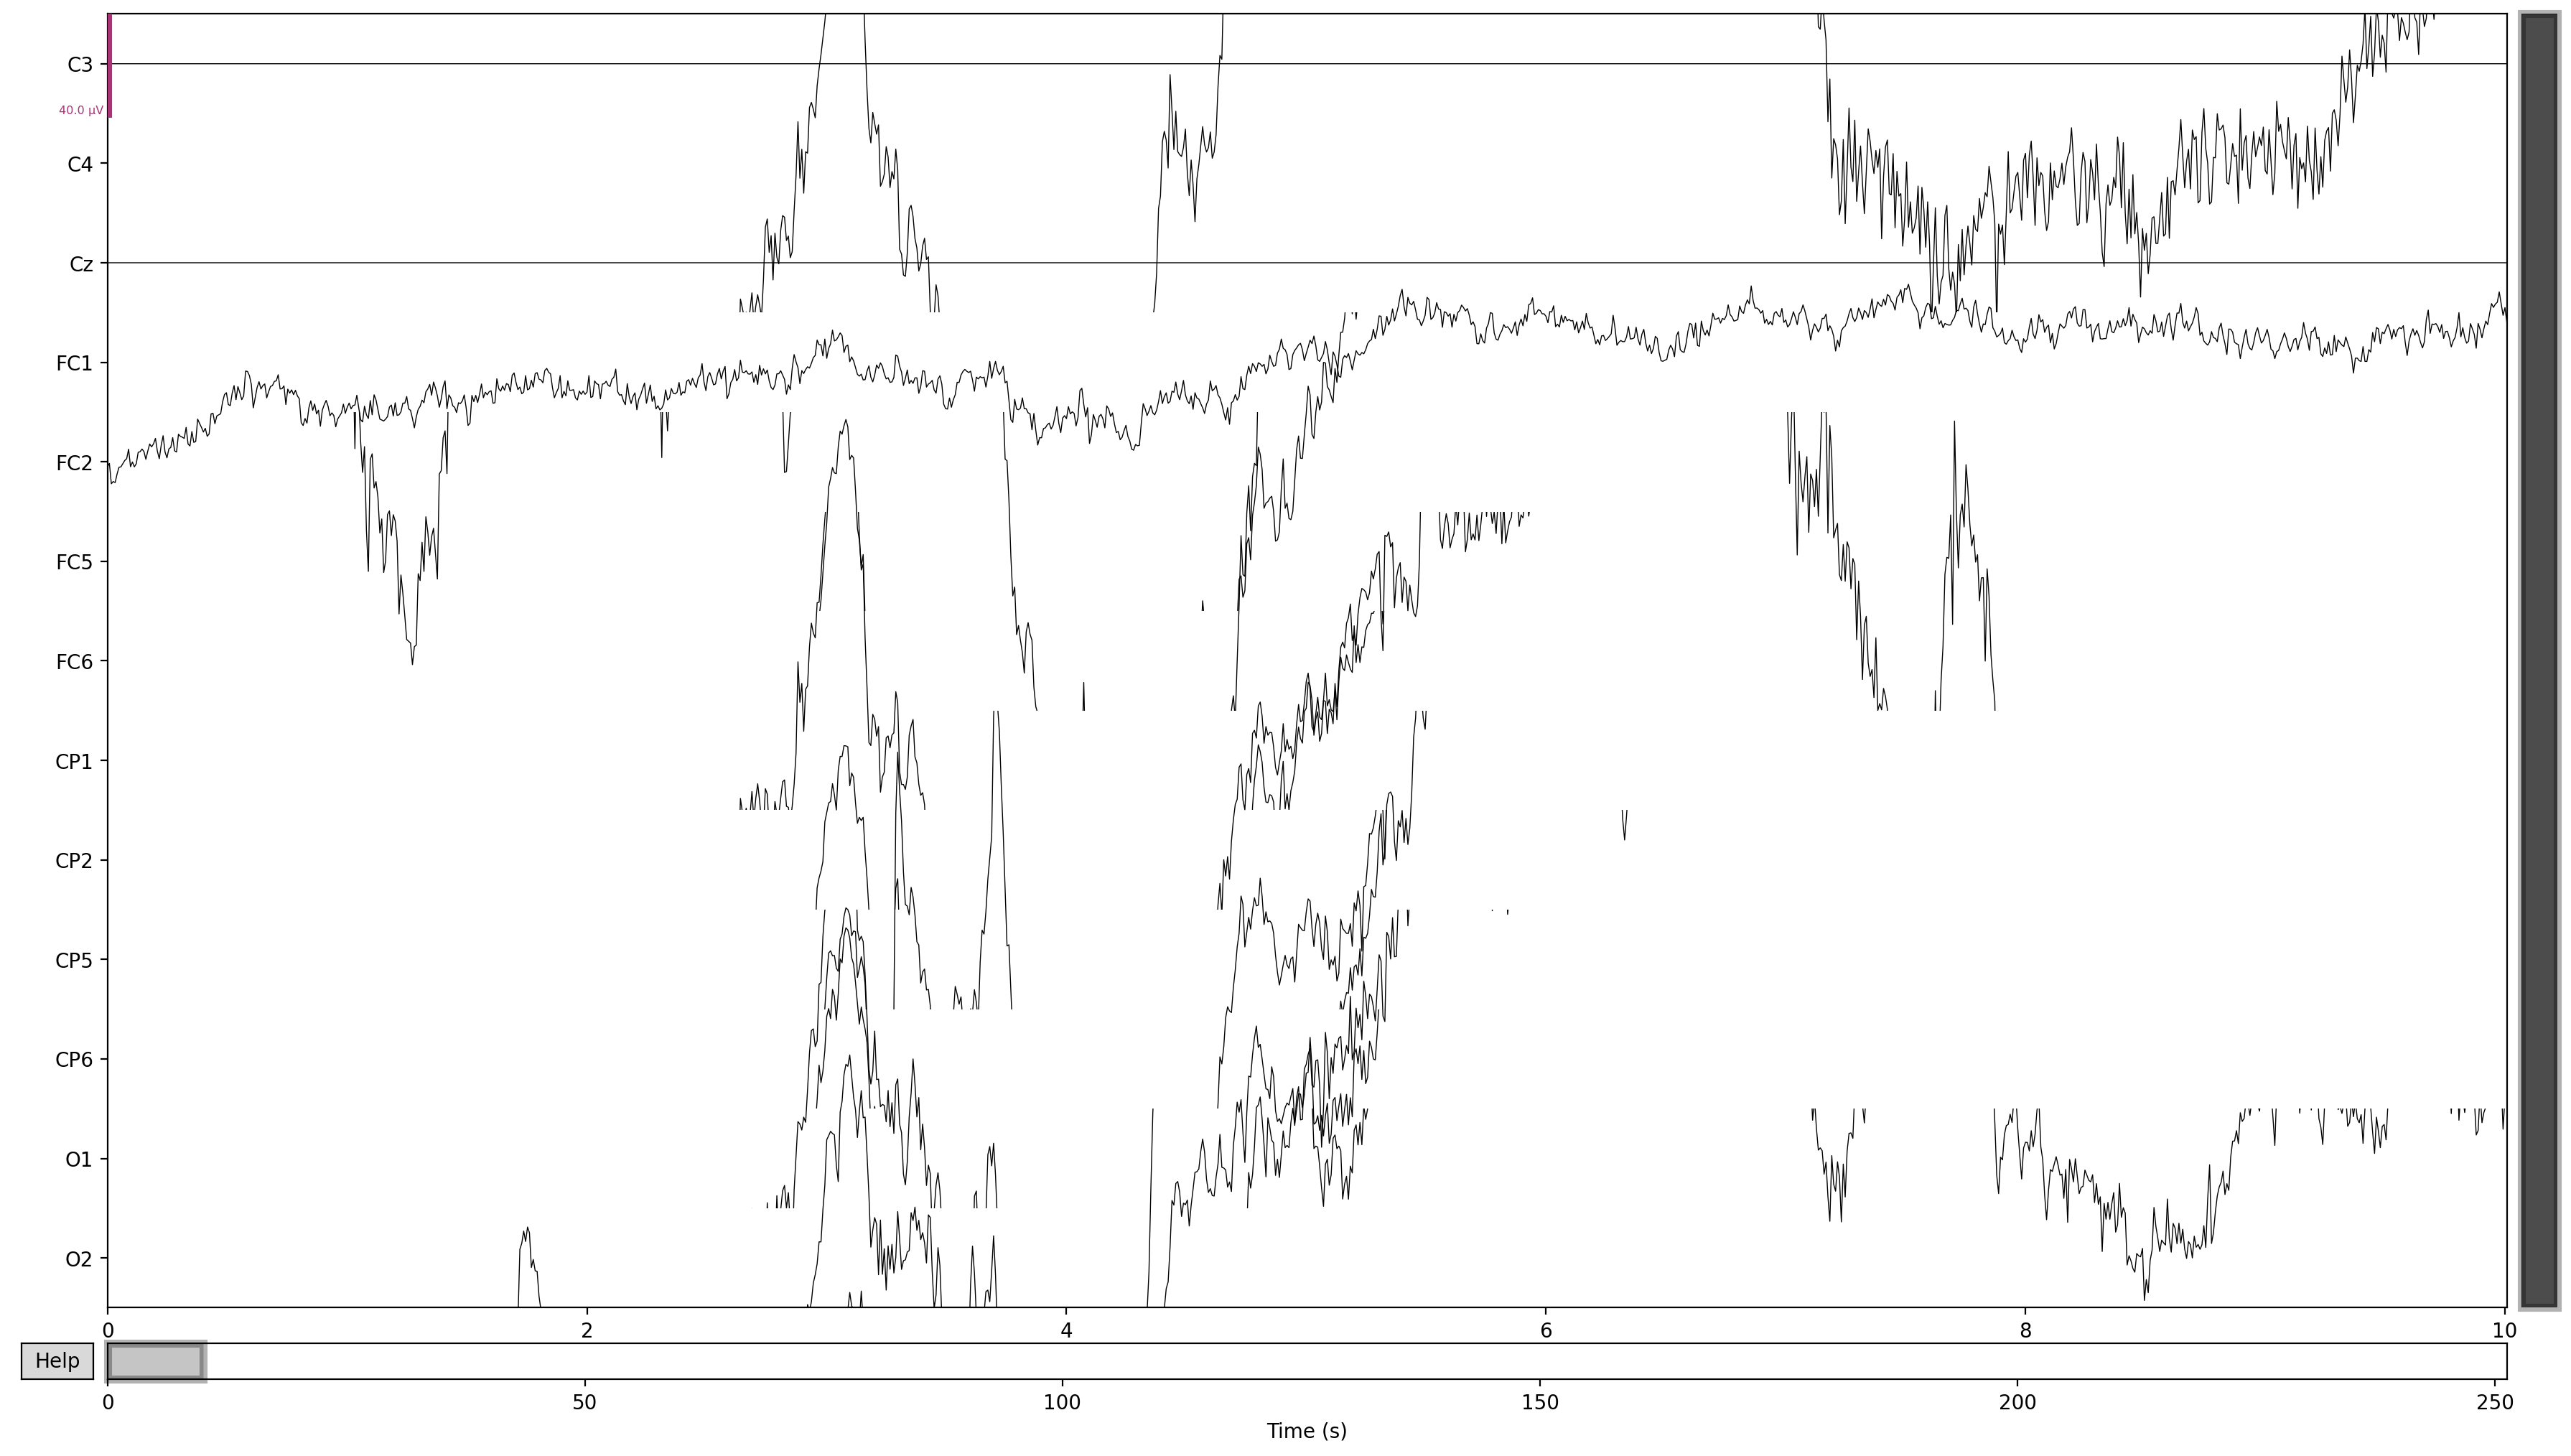

Channels marked as bad:
none


In [9]:
raw = mne.io.RawArray(eeg_data, info)
#raw_filter = raw.filter(l_freq = 0.5, h_freq = 60)
raw.plot()
#raw_filter.plot(scalings=dict(eeg=100e-6), duration=1, start=14)

In [10]:
# lets aling the time of event to the recording onset by seconds
start_time = eeg_stream['time_stamps'][0]
marker_stream['time_stamps'] -= start_time

events_num = len(marker_stream['time_series'])
zeros = np.zeros(len(marker_stream['time_series'])).reshape(events_num,1)
# need to solve the string thing
events = np.concatenate((marker_stream['time_stamps'].reshape(events_num,1),zeros,np.array(marker_stream['time_series']).reshape(events_num,1)),axis = 1)
print (events)

[['6.061276098218514' '0.0' 'Standard Trial']
 ['8.067574331915239' '0.0' 'Standard Trial']
 ['10.073315665591508' '0.0' 'Standard Trial']
 ['12.076322799257468' '0.0' 'Standard Trial']
 ['14.078997132892255' '0.0' 'Standard Trial']
 ['16.08192346652504' '0.0' 'Standard Trial']
 ['18.089166500227293' '0.0' 'Standard Trial']
 ['20.091997233888833' '0.0' 'Standard Trial']
 ['22.09672626754036' '0.0' 'Standard Trial']
 ['24.103975001256913' '0.0' 'Standard Trial']
 ['26.107891534891678' '0.0' 'Standard Trial']
 ['28.115785868634703' '0.0' 'Standard Trial']
 ['30.12277200233075' '0.0' 'Standard Trial']
 ['32.126387735974276' '0.0' 'Standard Trial']
 ['34.12823576963274' '0.0' 'Target Trial']
 ['36.13378750329139' '0.0' 'Target Trial']
 ['38.138053336937446' '0.0' 'Standard Trial']
 ['40.14323087062803' '0.0' 'Standard Trial']
 ['42.14774120427319' '0.0' 'Standard Trial']
 ['44.15478613798041' '0.0' 'Standard Trial']
 ['46.15900217165472' '0.0' 'Target Trial']
 ['48.164939605369' '0.0' 'Sta

In [80]:
# make sure no strings in marker
events[:,2] = np.char.replace(events[:,2], 'Standard Trial', '20')
events[:,2] = np.char.replace(events[:,2], 'Target Trial', '21')
# delete last row as it contains empty string
events = np.delete(events, -1, 0)

In [63]:
events = events.astype(float)
events[:,0] *= 125 # time to time stamp

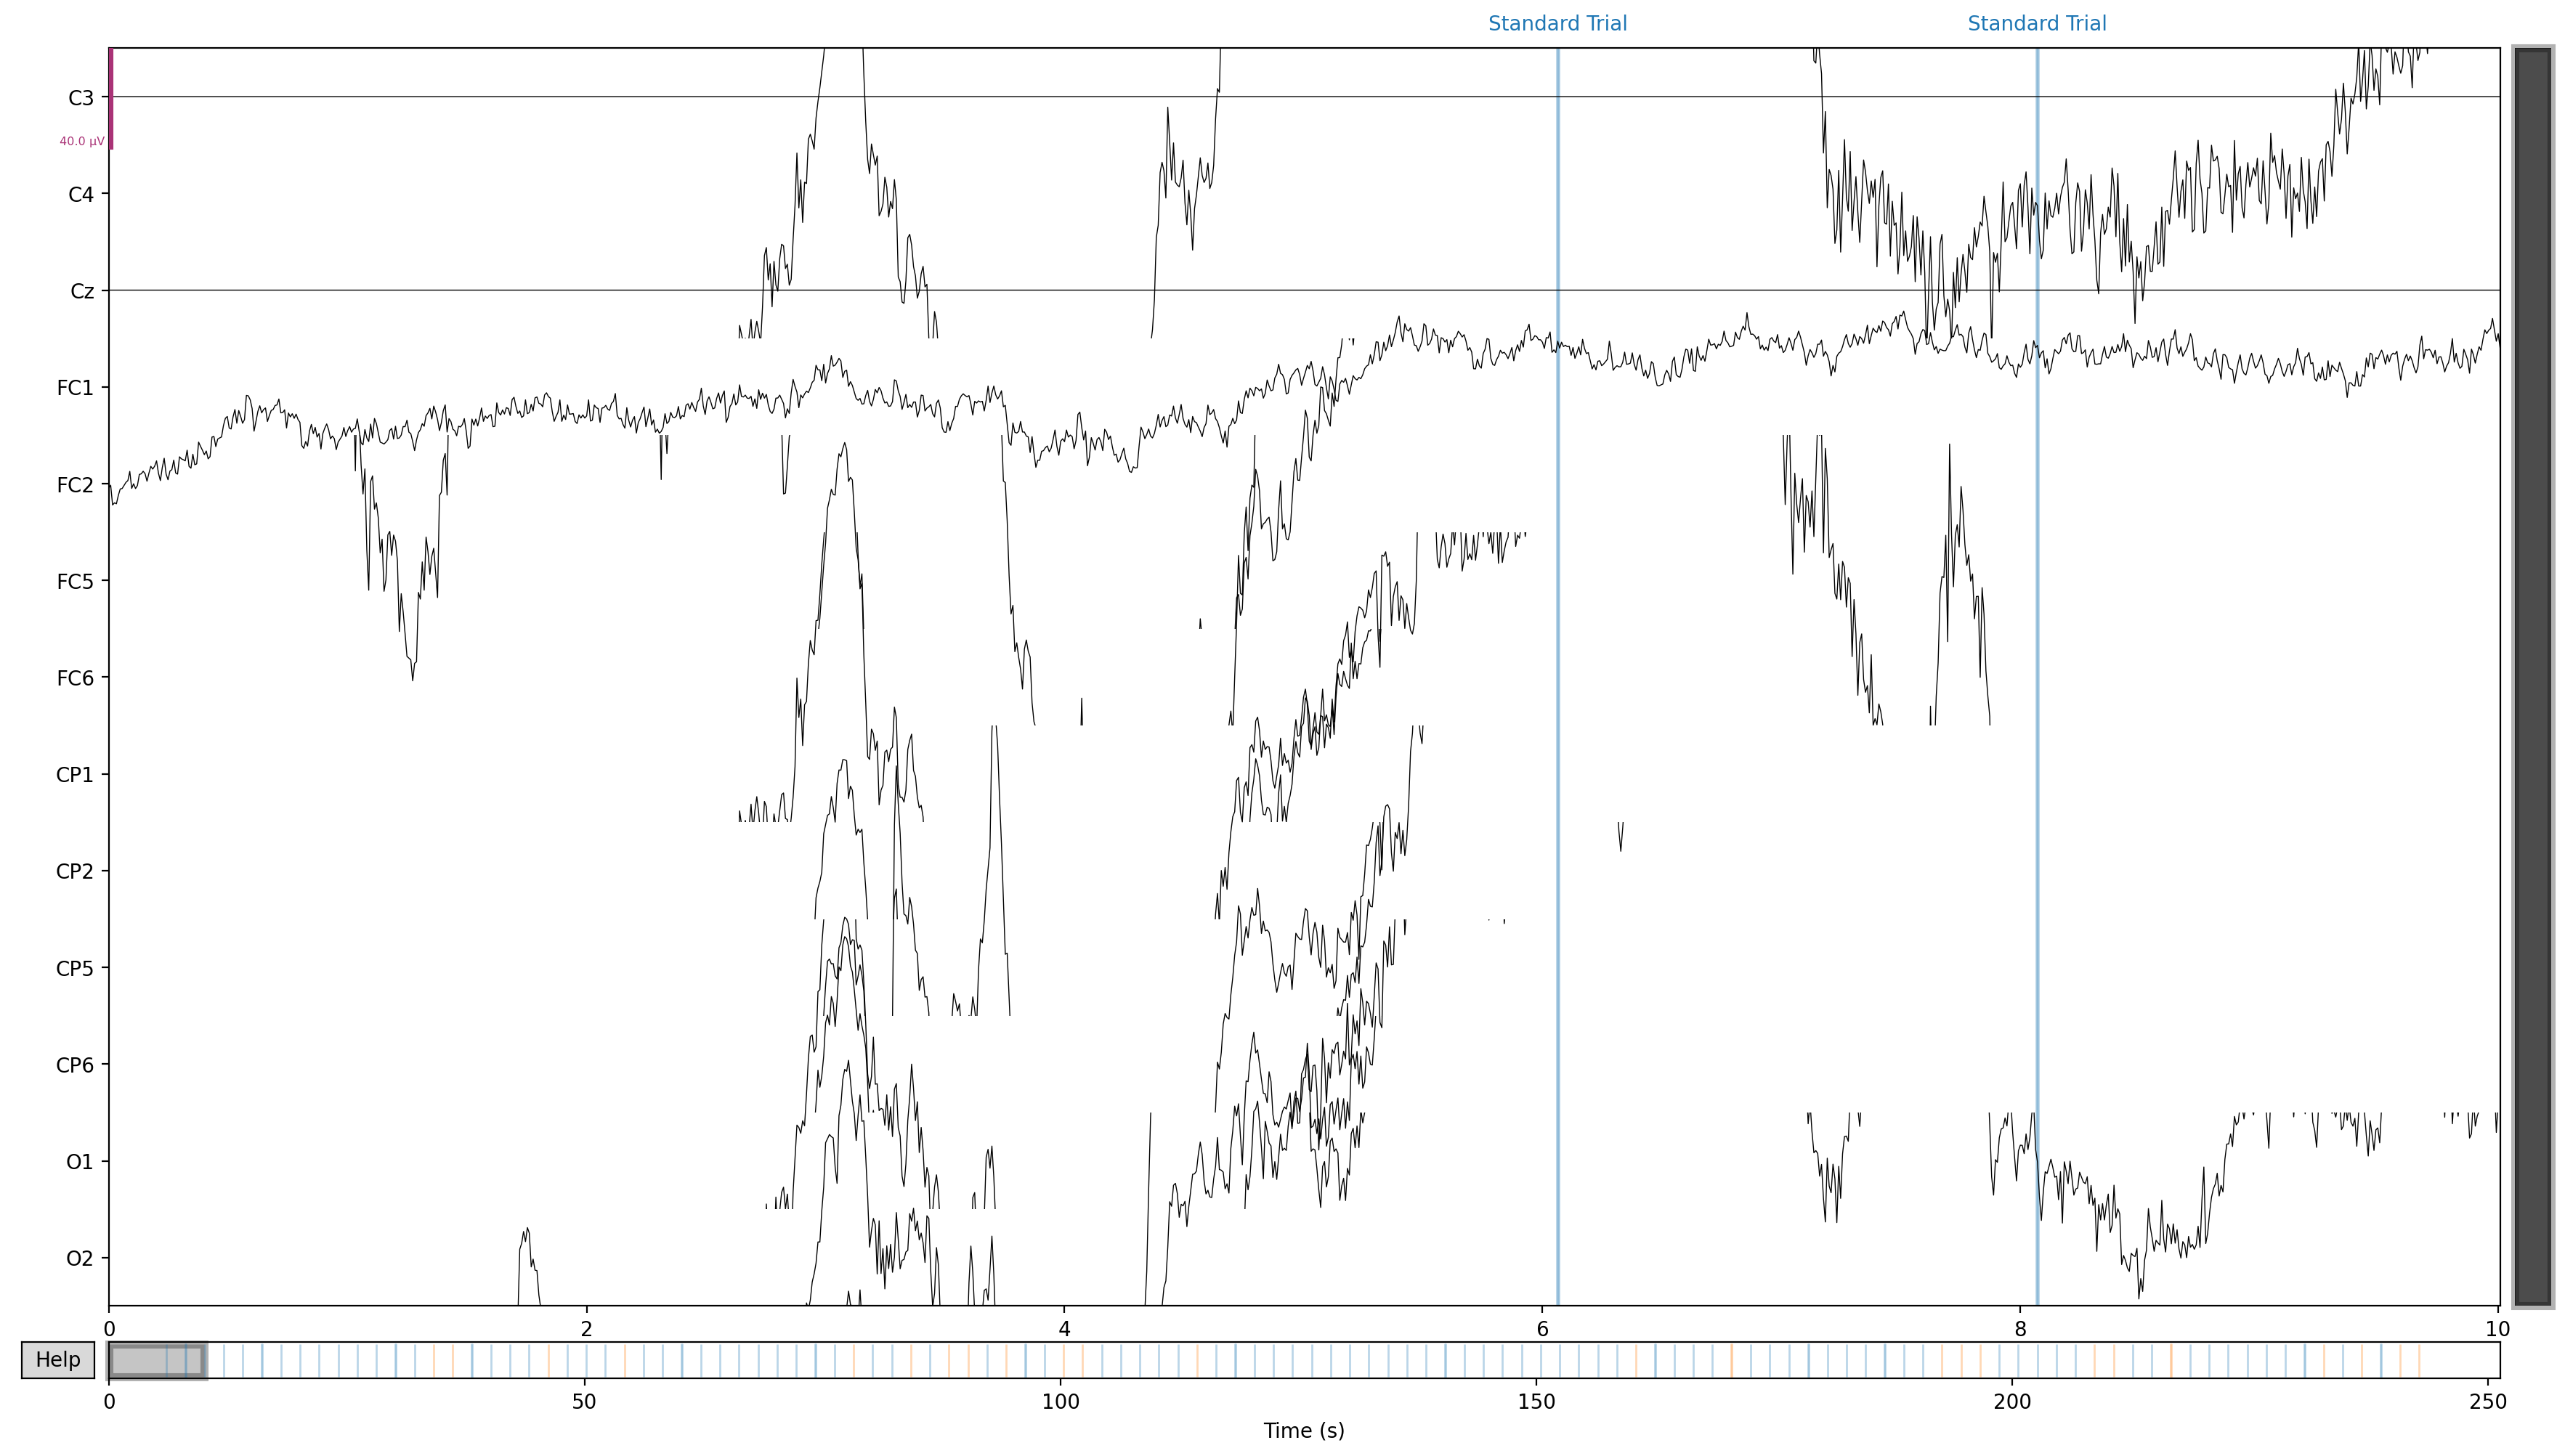

Channels marked as bad:
['FC5', 'C4', 'C3', 'FC2', 'FC1']


In [57]:
mapping = {20: 'Standard Trial', 21: 'Target Trial'}
# PAY ATTENTION. sfreq=raw.info['sfreq'] is not good. since raw.info['sfreq'] is 250 and not 125
annot_from_events = mne.annotations_from_events(
    events=events, event_desc=mapping, sfreq=125,
    orig_time=None)
raw.set_annotations(annot_from_events)
raw.plot()

## Preproccesing

### Mark bad channels and drop them

In [23]:
raw.filter(h_freq=2,l_freq = 60)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 2 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 61.25 Hz)
- Filter length: 207 samples (1.656 sec)



<RawArray | 13 x 31405 (251.2 s), ~3.1 MB, data loaded>

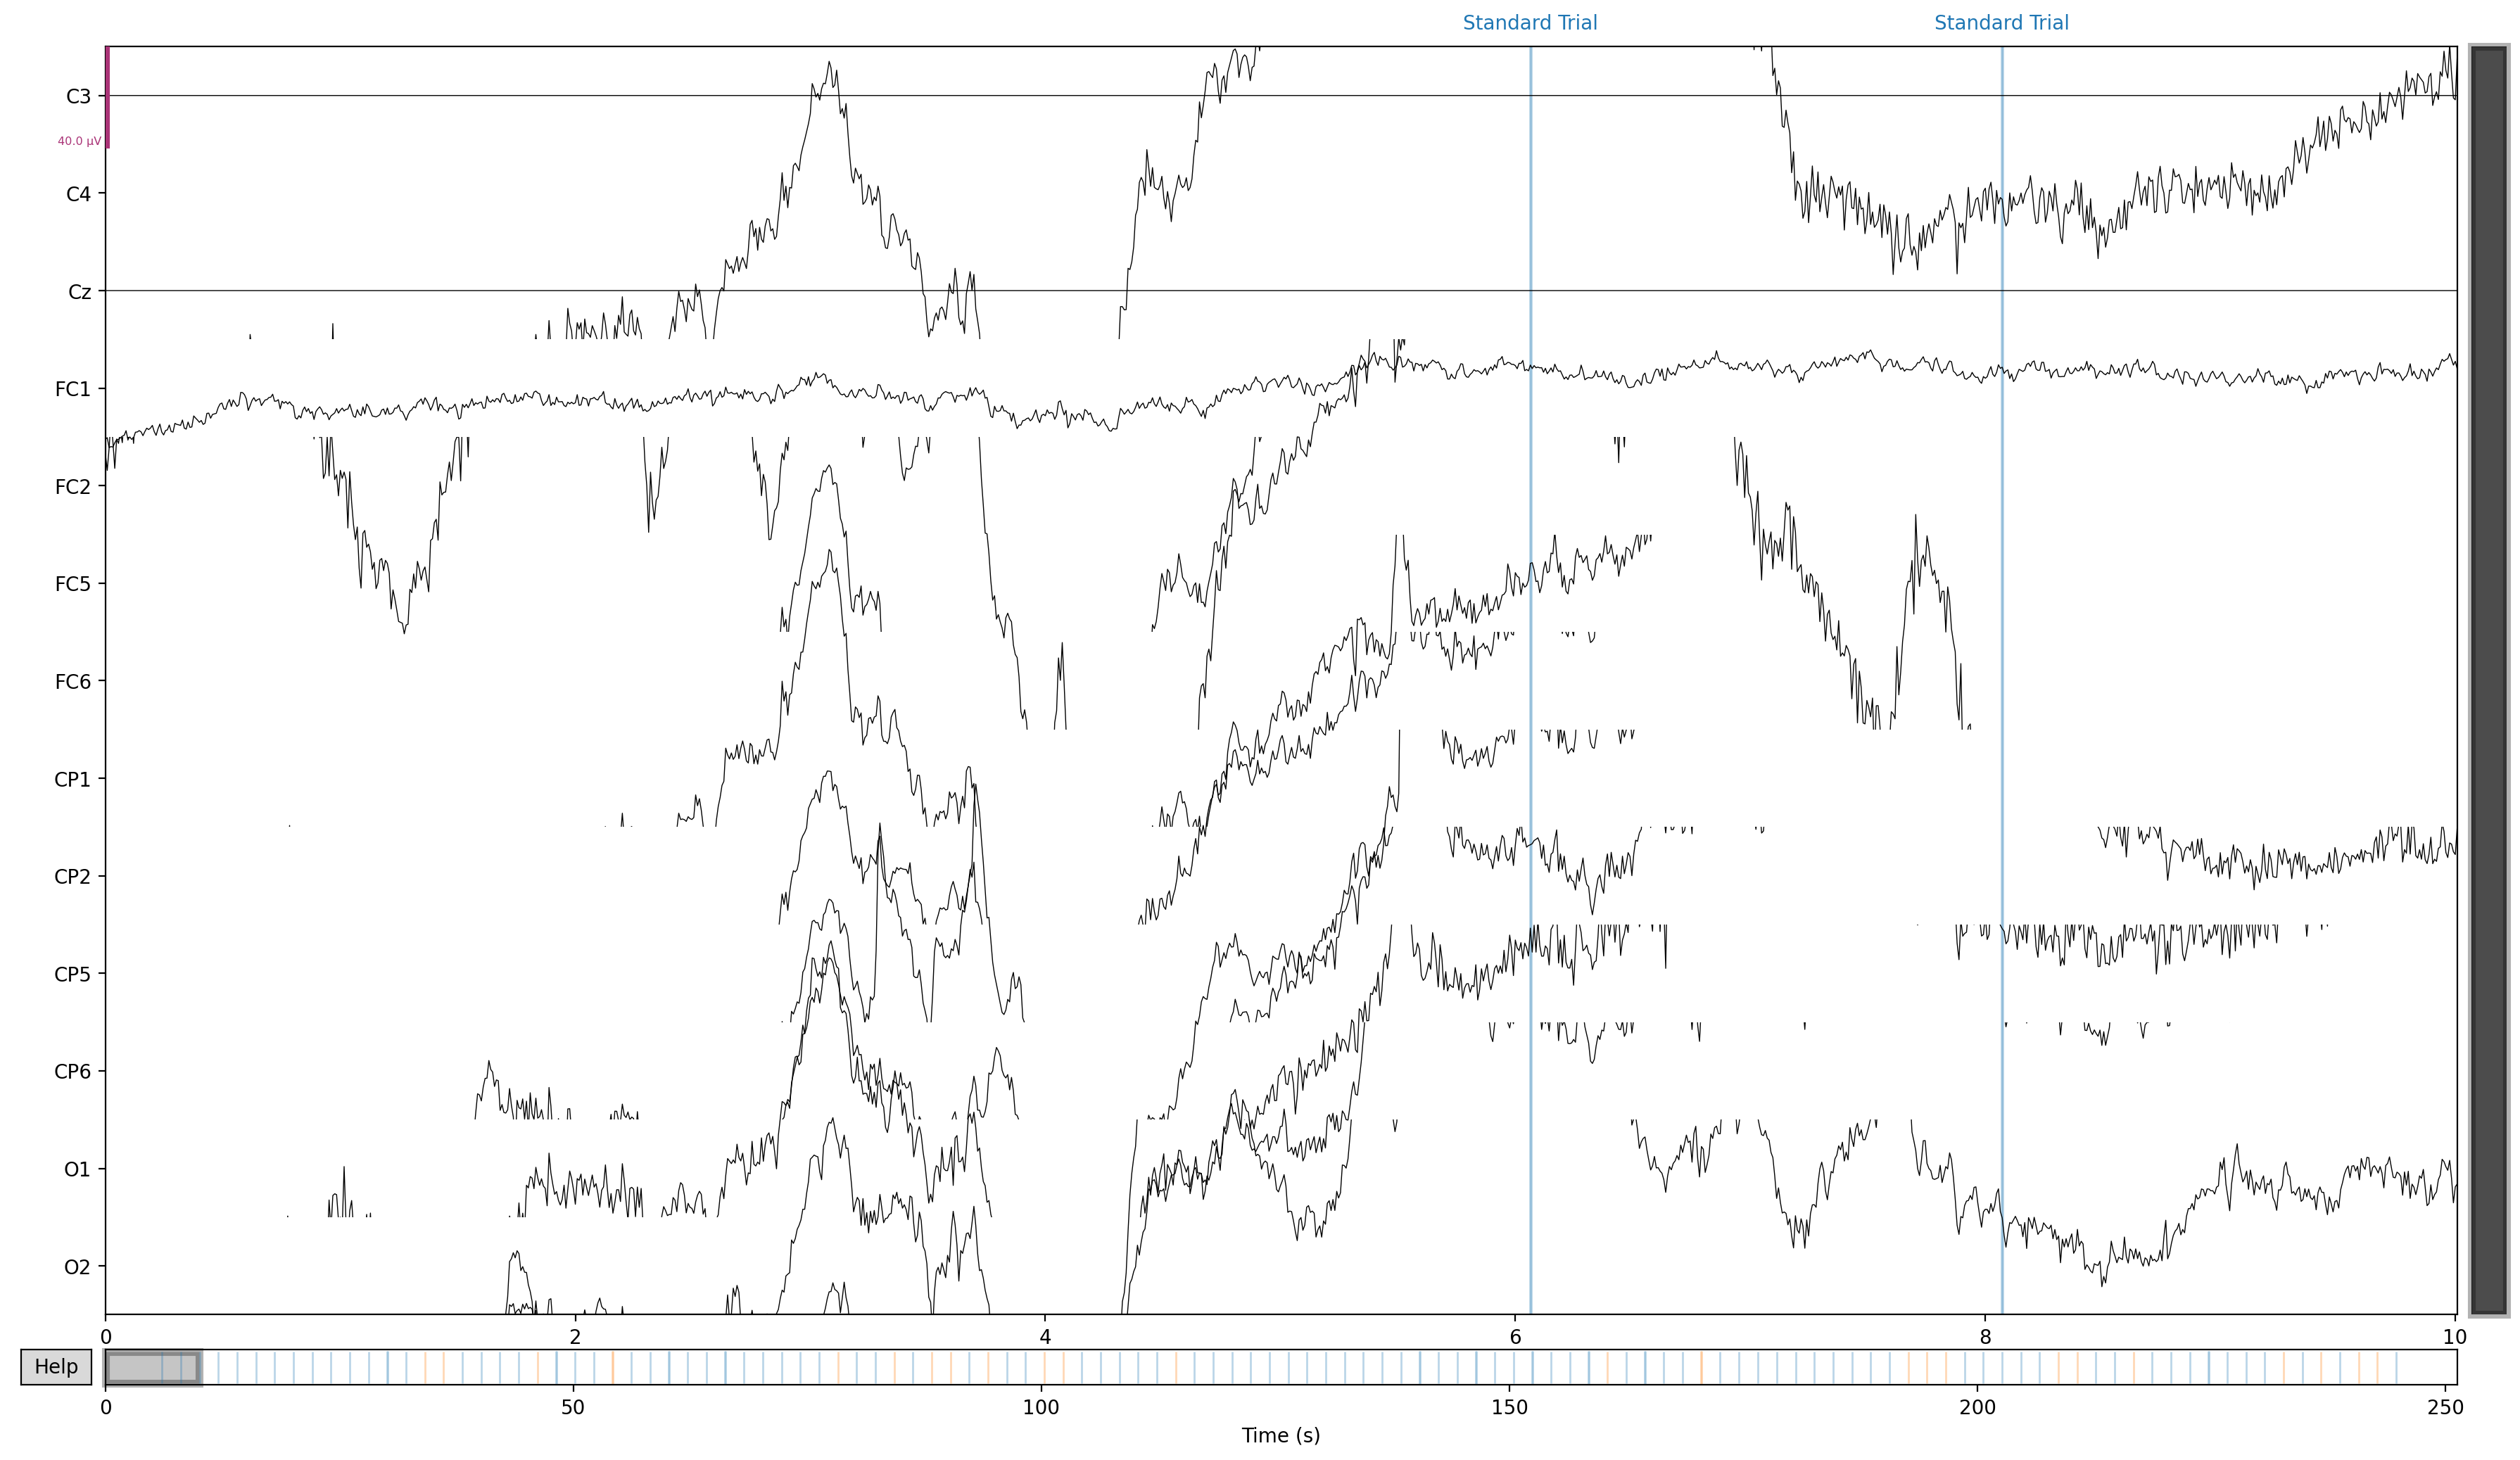

Channels marked as bad:
['FC1', 'FC5', 'FC2', 'C3']


In [16]:
raw.plot()

In [17]:
raw.drop_channels(raw.info['bads'])

<RawArray | 9 x 31405 (251.2 s), ~2.2 MB, data loaded>

## Epoching

In [25]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events_from_annot, tmin=-0.2, tmax=1, event_id=event_dict,detrend=0,baseline= (-0.2,0))



Used Annotations descriptions: ['Standard Trial', 'Target Trial']
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [60]:
## Plot evoked data

No projector specified for this dataset. Please consider the method self.add_proj.


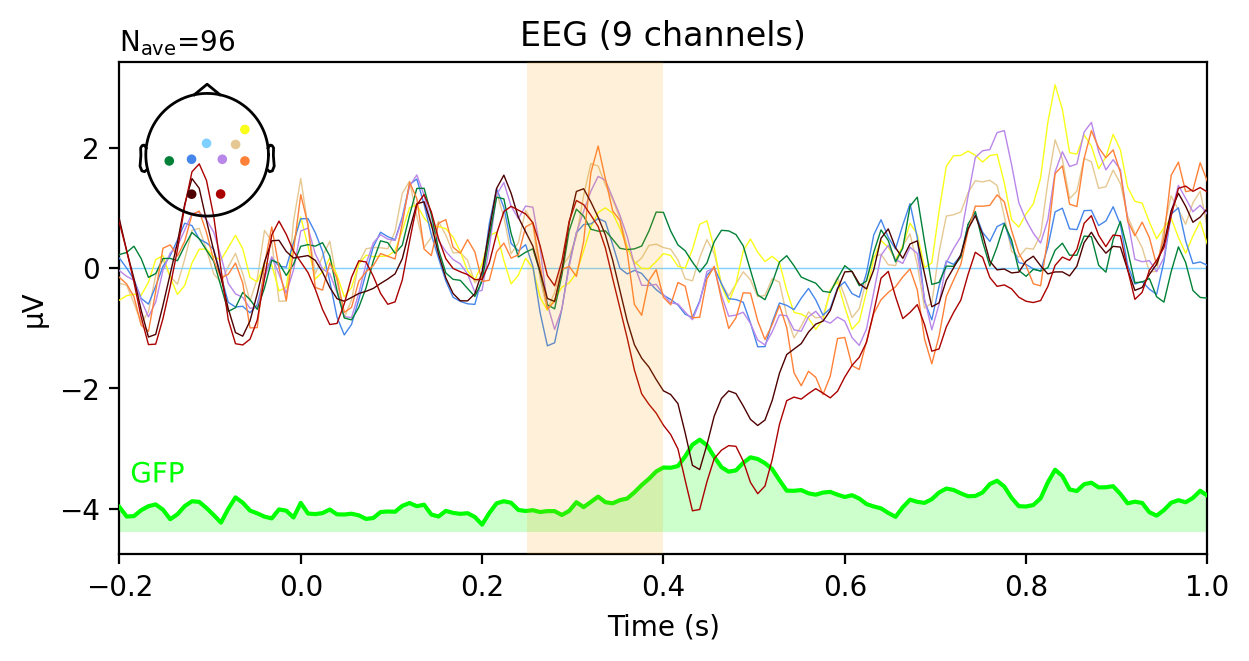

In [32]:
P300_window = [0.25,0.4]
par_picks = ['CP1','CP2'] # to plot only parietal

odd_evoked =  epochs['Target Trial'].average()
odd_evoked.plot(gfp=True,
    highlight=P300_window)

odd_evoked.plot_joint(picks='eeg',times=[0,0.2,0.3,0.4])


stand_evoked =  epochs['Standard Trial'].average()
stand_evoked.plot(gfp=True,
    highlight=P300_window)

In [27]:
#stan_evoked = epochs['Standard Trial'].average()
#odd_evoked = epochs['Target Trial'].average()

mne.viz.plot_compare_evokeds(dict(stand=stand_evoked, odd=odd_evoked),combine='mean' )

combining channels using "mean"
combining channels using "mean"


[<Figure size 1600x1200 with 1 Axes>]

In [38]:

epochs.plot_image(picks='eeg', combine='mean')
epochs['Target Trial'].plot_image(picks='eeg', combine='mean')

Using data from preloaded Raw for 120 events and 151 original time points ...
0 bad epochs dropped
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
Using data from preloaded Raw for 24 events and 151 original time points ...
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


[<Figure size 1280x960 with 3 Axes>]

We can also plot sensor locations:

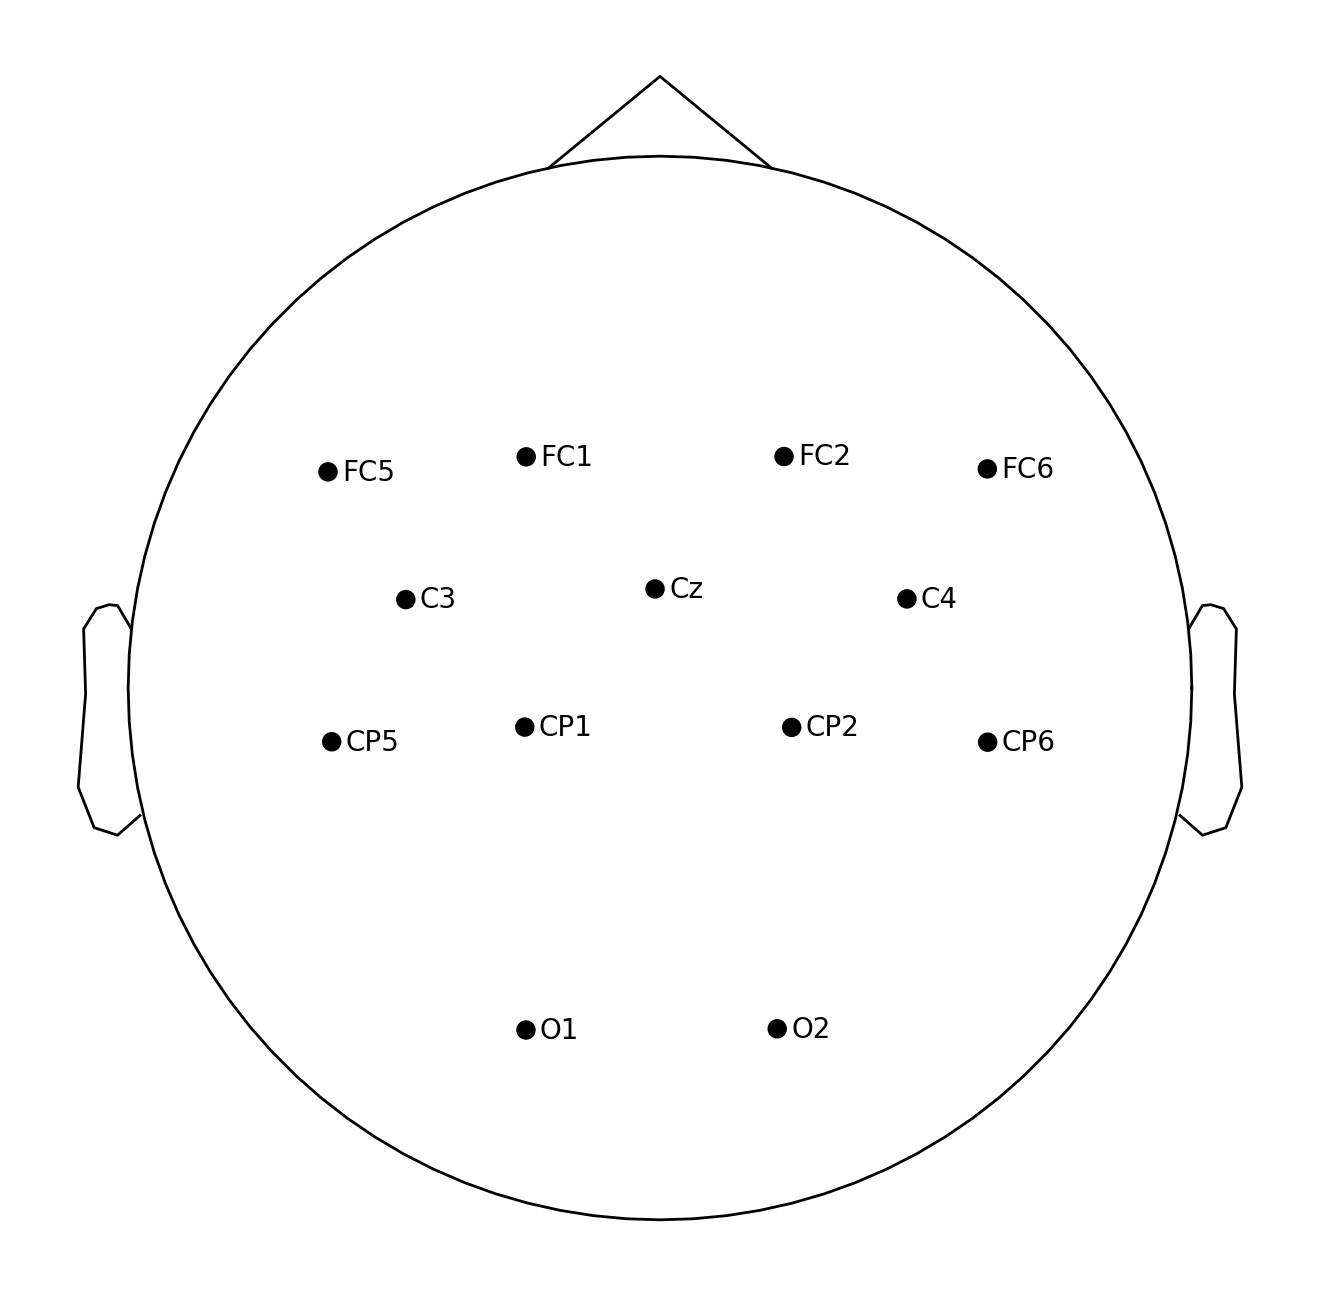

In [17]:
raw.plot_sensors(show_names= True)

In **3d** its even cooler:

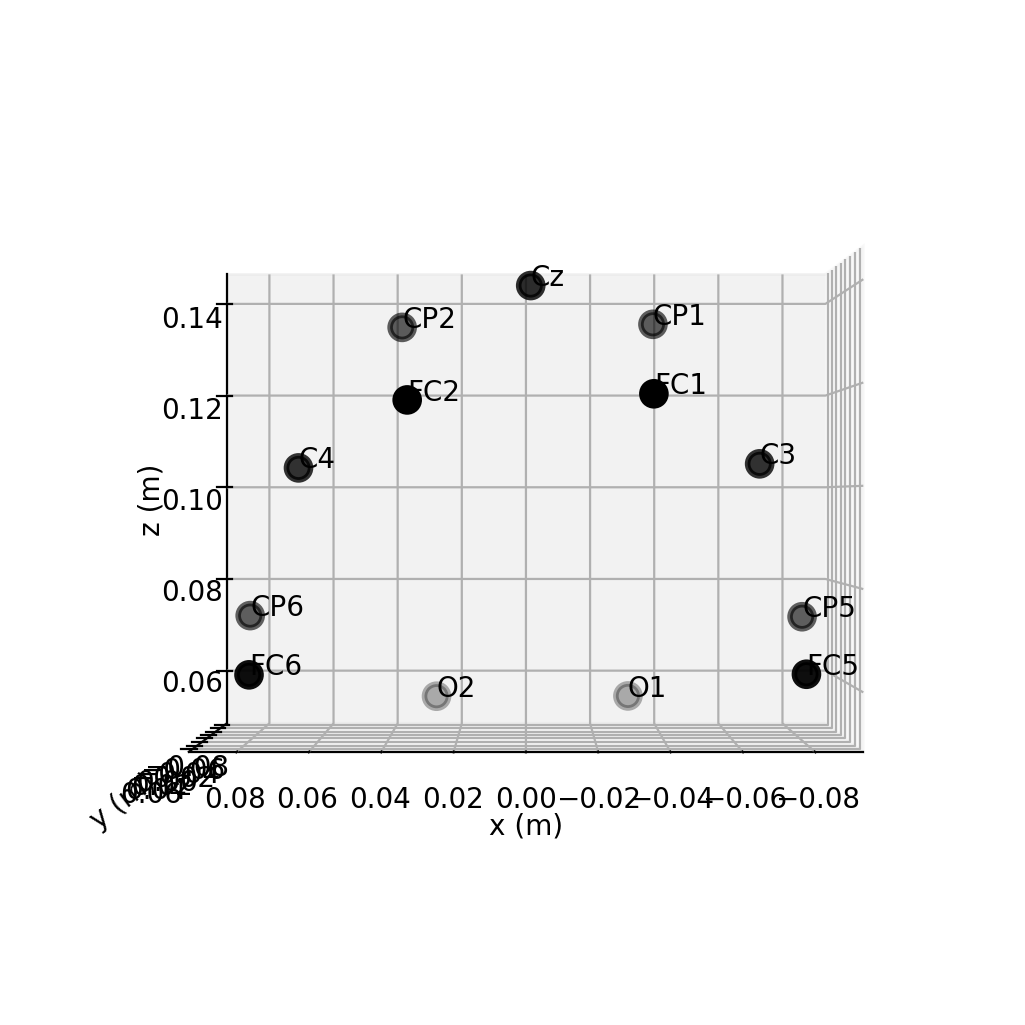

In [18]:
raw.plot_sensors(show_names= True,kind= '3d')